In [1]:
!pip install trl
!pip install datasets
!pip install lighteval[math]
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Huggingface notebook login
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `test` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `test`


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformers import AutoModelForCausalLM
import re
from datasets import load_dataset, Dataset
from trl import GRPOConfig, GRPOTrainer
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:


model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
)

tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct")


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:


SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> #### answer here </answer>"
)

def extract_hash_answer(text: str) -> str | None:
    # Search for ####
    match = re.search(r"####\s*(.*)", text)
    if match:
        return match.group(1)
    return None

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split]
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_hash_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r and r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_hash_answer(r) for r in responses]
    return [0.5 if r and r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^(.*?)\n####\s(.*?)$"  # Matches reasoning followed by #### and answer
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r, re.DOTALL) for r in responses]  # re.DOTALL allows '.' to match newlines
    return [0.5 if match else 0.0 for match in matches]

In [ ]:

training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    logging_steps = 1,
    per_device_train_batch_size = 6,
    gradient_accumulation_steps = 4,
    num_generations = 6,
    max_prompt_length = 512,
    max_completion_length = 256,
    num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 1000,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "wandb",
    output_dir = "outputs",
)

In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sv2795 (ayinalalikhith-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
To find the minimum grade Ahmed needs to beat Emily, we first need to determine Ahmed's final grade. Since the final assignment is worth the same amount as all the other assignments, Ahmed's final grade will be the average of his 9 assignments. Ahmed's total score, including his final assignment, will be \(91 + 92 + 90 = 273\), and his final grade will be \(\frac{273}{9}\).

Now, let's calculate the average score of the 9 assignments and the final assignment for Ahmed:
\[ \text{Average score of the 9 assignments} = \frac{273}{9} \]

Since the final assignment is wort

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,-0.000000
9,-0.000000
10,0.000000


-------------------- Question:
In a graveyard, there are 20 skeletons.  Half of these skeletons are adult women, and the remaining number are split evenly between adult men and children.  If an adult woman has 20 bones in their body, and a male has 5 more than this, and a child has half as many as an adult woman, how many bones are in the graveyard? 
Answer:
375 
Response:
First, we need to determine the number of adult women, adult men, and children in the graveyard. Given that half of the 20 skeletons are adult women, we calculate:

\[ \text{Number of adult women} = \frac{20}{2} = 10 \]

Next, we calculate the number of adult men. Since the remaining skeletons (which are split evenly between adult men and children) are 10, we divide this by 2:

\[ \text{Number of adult men} = \frac{10}{2} = 5 \]

Now, we can find the number of children by calculating half the number of adult women:

\[ \text{Number of children} = \frac{10}{2} = 5 \]

Next, we calculate the total number of bones in ea

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,-0.000000
9,-0.000000
10,0.000000


Streaming output truncated to the last 5000 lines.
First, 30 months * 3 kg/month = 90 kg of weight loss.
So, the boxer will weigh 97 - 90 = 7 kg.

On the day of the fight, the weight of the boxer will be exactly 7 kg.

#### 7
The weight of the boxer on the day of the fight is 7 kg. 
Extracted:
7
-------------------- Question:
Sunny bakes 8 cakes. Then she gives away 2 cakes. Sunny wants to put candles on the remaining cakes. If she puts 6 candles on each cake, how many candles will she use in total? 
Answer:
36 
Response:
To solve the problem, we start by determining the number of cakes Sunny has after giving away 2.

1. Sunny initially baked 8 cakes.
2. She gives away 2 cakes, so the number of remaining cakes is:
\[ 8 - 2 = 6 \]

Now, to find out the total number of candles they will use, we multiply the number of remaining cakes by the number of candles per cake:

\[ 6 \text{ cakes} \times 6 \text{ candles per cake} = 36 \text{ candles} \]

#### 36
We calculated the total number of c

TrainOutput(global_step=1000, training_loss=0.02842331444551813, metrics={'train_runtime': 10987.1151, 'train_samples_per_second': 2.184, 'train_steps_per_second': 0.091, 'total_flos': 0.0, 'train_loss': 0.02842331444551813})

In [ ]:
# Save the trained mdoel
trainer.save_model("grpo_0.5B_qwen_full_gsm8k")

In [ ]:
# Push the model to huggingfacehub
trainer.push_to_hub('grpo_0.5B_qwen_full_gsm8k')

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/6.26k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/rocketpenguin25603/outputs/commit/d93e7de8cf39ea15ed20f9722b8a8685ae2ba923', commit_message='rndomGuyTf/grpo_0.5B_qwen_full_gsm8k', commit_description='', oid='d93e7de8cf39ea15ed20f9722b8a8685ae2ba923', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rocketpenguin25603/outputs', endpoint='https://huggingface.co', repo_type='model', repo_id='rocketpenguin25603/outputs'), pr_revision=None, pr_num=None)

In [ ]:
# Lighteval
!lighteval accelerate \
     "model_name=/content/grpo_0.5B_qwen_full_gsm8k,max_length=2000,dtype=float32" \
    "lighteval|gsm8k|3|1" \
    --output-dir="./evals/" --save-details

[2025-05-09 22:54:15,390] [    INFO]: NumExpr defaulting to 12 threads. (utils.py:162)
[2025-05-09 22:54:15,525] [    INFO]: PyTorch version 2.6.0+cu124 available. (config.py:54)
[2025-05-09 22:54:15,526] [    INFO]: Polars version 1.21.0 available. (config.py:66)
[2025-05-09 22:54:15,527] [    INFO]: Duckdb version 1.2.2 available. (config.py:77)
[2025-05-09 22:54:15,527] [    INFO]: TensorFlow version 2.18.0 available. (config.py:112)
[2025-05-09 22:54:15,528] [    INFO]: JAX version 0.5.2 available. (config.py:125)
2025-05-09 22:54:15.977491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746831255.998672   54641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746831256.005244   54641 cuda_blas.cc:1418] Unable to register cuBLAS factory:

In [ ]:
# Lighteval on base 0.5B isntruct
!lighteval accelerate \
     "model_name=Qwen/Qwen2.5-0.5B-Instruct,max_length=2000,dtype=float32" \
    "lighteval|gsm8k|3|1" \
    --output-dir="./evals/" --save-details

[2025-05-09 06:35:32,065] [    INFO]: NumExpr defaulting to 2 threads. (utils.py:162)
[2025-05-09 06:35:32,289] [    INFO]: PyTorch version 2.6.0+cu124 available. (config.py:54)
[2025-05-09 06:35:32,290] [    INFO]: Polars version 1.21.0 available. (config.py:66)
[2025-05-09 06:35:32,294] [    INFO]: Duckdb version 1.2.2 available. (config.py:77)
[2025-05-09 06:35:32,295] [    INFO]: TensorFlow version 2.18.0 available. (config.py:112)
[2025-05-09 06:35:32,296] [    INFO]: JAX version 0.5.2 available. (config.py:125)
2025-05-09 06:35:34.600182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746772534.851648     916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746772534.920562     916 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

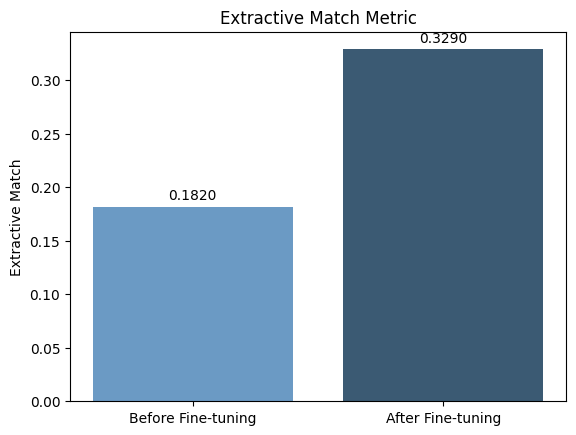

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Before Fine-tuning', 'After Fine-tuning']
values = [0.182, 0.329]

# Colors matching the chart
colors = ['#6b9ac4', '#3b5a73']  # light blue and dark blue

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=colors)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Set title and labels
ax.set_title('Extractive Match Metric')
ax.set_ylabel('Extractive Match')

plt.show()
